# Drowsiness Driving Detection
# 운전자 졸음 감지

<br>

<br>

## 방향

#### <방법 1> - 이론

**1. 얼굴 영역 추출**
- OpenCV의 HOG face pattern
- OpenCV의 Face Landmark Estimation algorithm을 이용해 얼굴 랜드마크 사용
<br><br>

**2. 눈 영역 추출**
- 랜드마크 이용
- Eye Aspect Ratio(EAR)
<br><br>

**3. 운전자 졸음 감지**

<개념>
- 계산된 EAR은 눈을 뜨고 있을 땐 0이 아닌 어떤 값
- 눈을 감을 땐 0에 가까운 값
- 임계값을 설정하여 임계값보다 EAR값이 작아지면 졸음운전 중
    - 임계값은 눈을 가장 크게 떴을 때 EAR값의 50%
<br>

<적용>
- 운전자가 눈을 뜨고 있을 때 평균 EAR값 결정
- 운전자가 눈을 감고 있을 때 평균 EAR값 결정
- 위 두 값을 이용해 눈을 뜨고 있는 상태의 50%가 되는 EAR 값 결정

<br>

**4. 운전자 졸음 시 경고**

<br>

#### <방법 2> - 이론

**1. 얼굴 영역 추출**
- OpenCV의 haarcasdcade
<br><br>

**2. 눈 영역 추출**
- 그레이 변환 후 반복적인 labeling
- binary 영상으로부터 연결된 구성성분 찾기
- R,G,B 채널간의 색차 구하기(적은 것이 눈 영역)

*우리 데이터는 흑백이여서 R,G,B 채널 사용 가능한지 잘 모르겠음*
<br><br>

**3. 운전자 졸음 감지**
- 이진화 방법(눈을 감았는지 안감았는지 확인)
- 검은색은 0으로, 흰색은 1로 표현
- 0으로 표현된 픽셀 수 세어 눈 개폐 여부 확인
    - 눈을 떴을 때는 검은색 픽셀 개수가 평균보다 많다
    - 눈을 감았을 때는 검은색 픽셀 개수가 평균보다 작다.

<br>

![이미지](이진화이미지.png)

<br>

#### <방법 1> - 적용

이미지 불러오기

In [3]:
import PIL.Image
import PIL.ImageDraw
import face_recognition

from PIL import Image

In [4]:
# Load the jpg file into a numpy array
image = face_recognition.load_image_file("image1.jpg")

# Find all the faces in the image using the default HOG-based model.
# This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
# See also: find_faces_in_picture_cnn.py
face_locations = face_recognition.face_locations(image)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    pil_image.show()

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 547, Left: 204, Bottom: 932, Right: 589


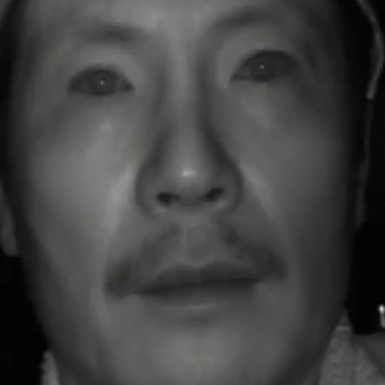

In [5]:
pil_image

눈 영역 추출 - 랜드마크 이용

In [1]:
# Facial landmarks with dlib, OpenCV, and PythonPython

# import the necessary packages
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2


def show_raw_detection(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    # show the output image with the face detections + facial landmarks
    cv2.imshow("Output", image)
    cv2.waitKey(0)


def draw_individual_detections(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            clone = image.copy()
            cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 0, 255), 2)

            # loop over the subset of facial landmarks, drawing the
            # specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)

            # extract the ROI of the face region as a separate image
            (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
            roi = image[y:y + h, x:x + w]
            roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)

            # show the particular face part
            cv2.imshow("ROI", roi)
            cv2.imshow("Image", clone)
            cv2.waitKey(0)

        # visualize all facial landmarks with a transparent overlay
        output = face_utils.visualize_facial_landmarks(image, shape)
        cv2.imshow("Image", output)
        cv2.waitKey(0)


# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# load the input image, resize it, and convert it to grayscale
image = cv2.imread('image1.jpg')
image = imutils.resize(image, width=500)
show_raw_detection(image, detector, predictor)
draw_individual_detections(image, detector, predictor)

![이미지](1.png)

![이미지](4.png)

![이미지](5.png)

## 이미지를 줄이는 방법

1. 눈, 코, 입 & 정면을 바라보는 이미지로 졸음감지 시스템을 만든다.
2. 안경, 마스크, 측면을 바라보는 이미지를 추가하여 감지가 잘 되는지 확인한다.

+ 정면(눈, 코, 입 다 나옴)
+ 안경, 정면
+ 마스크, 정면
+ 안경, 마스크, 정면
+ 안경, 측면
+ 마스크, 측면
+ 안경, 마스크, 측면

+ 모자

https://aihub.or.kr/unitysearch/list.do?kwd=%EC%A1%B8%EC%9D%8C%EC%9A%B4%EC%A0%84